# DAE - Denoising Auto Encoder

In [24]:
import torch
import torchvision
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
import copy
import wandb

torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cpu_count = os.cpu_count()
torch.manual_seed(123) # Set the random seed for reproducible results

# Custom transforms to add noise to images

In [25]:
from typing import Any
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
import random


class AddGaussianNoise():
    def __init__(self, mean=0.0, std=1.0):
        self.mean = mean
        self.std = std

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Input image.

        Returns:
            PIL Image: Image with added noise.
        """
        img = transforms.ToTensor()(img)
        noise = torch.randn_like(img) * self.std + self.mean
        noisy_img = img + noise
        noisy_img = torch.clamp(noisy_img, 0, 1)  # Clip values to [0, 1]
        return transforms.ToPILImage()(noisy_img)


class AddSaltAndPepperNoise(object):
    def __init__(self, prob=0.05):
        self.prob = prob

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Input image.

        Returns:
            PIL Image: Image with salt and pepper noise.
        """
        img = transforms.ToTensor()(img)
        noisy_img = img.clone()

        # Apply salt and pepper noise to the image
        for i in range(img.size(1)):
            for j in range(img.size(2)):
                if random.random() < self.prob:
                    # Pepper noise
                    noisy_img[:, i, j] = 0.0
                elif random.random() < self.prob:
                    # Salt noise
                    noisy_img[:, i, j] = 1.0

        return transforms.ToPILImage()(noisy_img)

In [26]:
batch_size = 128
# training_data_noisy = torchvision.datasets.FashionMNIST(
#     root='./data/',
#     download=True,
#     train=True,
#     transform=transforms.Compose([
#     AddSaltAndPepperNoise(prob=0.05),
#     transforms.ToTensor(), # Transform back to Tensor
#     torch.flatten,
# ])
# )

training_data = torchvision.datasets.FashionMNIST(
    root='./data/',
    download=True,
    train=True,
    transform=transforms.Compose([
    transforms.ToTensor(), # Transform back to Tensor
    torch.flatten,
])
)

testing_data = torchvision.datasets.FashionMNIST(
    root='./data/',
    train=False,
    download=True,
    transform=transforms.Compose([
    AddSaltAndPepperNoise(prob=0.05),
    transforms.ToTensor(),
    torch.flatten, # Transform back to Tensor
])
)
# X_train, y_train = training_data
# X_test, y_test = test_data

In [27]:
import random
def add_noise(inputs,prob=0.1):
     # noise = inputs+torch.rand_like(inputs)*noise_factor
     # noise = torch.clip(noise,0.,1.)
     noisy_img = inputs.clone()

     for i in range(inputs.size(1)):
          if random.random() < prob:
               noisy_img[:, i] = 0.0
          elif random.random() < prob:
               noisy_img[:, i] = 1.0

     return noisy_img


In [28]:
# Transform Dataset into dataloader instance for batching and shuffling capabilities
train_loader = torch.utils.data.DataLoader(training_data,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=0, # cpu_count
                                          )

test_loader = torch.utils.data.DataLoader(testing_data,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=0, # cpu_count
                                          )

# Preview transformed images

Training data size :60000


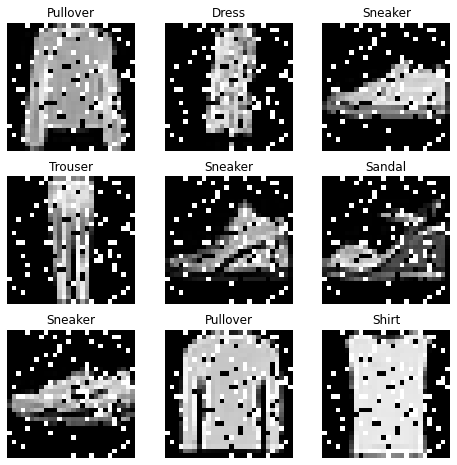

In [29]:
# Get image through dataset class
print(f'Training data size :{len(training_data)}')
labels_dataset = {'0' : 'T-shirt/top',
'1' :'Trouser',
'2'	:'Pullover',
'3'	:'Dress',
'4'	:'Coat',
'5'	:'Sandal',
'6'	:'Shirt',
'7'	:'Sneaker',
'8'	:'Bag',
'9'	:'Ankle boot'}

def view_data(X_train = train_loader):
    data_view, labels_view = next(iter(X_train))
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    data_view = add_noise(data_view)
    for i in range(1, cols * rows + 1):
        imgs, labels = data_view.detach().numpy(), labels_view.detach().numpy()
        img = imgs[i].reshape(28,28)
        label = str(int(labels[i]))
        figure.add_subplot(rows, cols, i)
        # plt.title(labels_dataset[str(int(labels_view[i]))])
        plt.title(labels_dataset[label])
        plt.axis("off")
        plt.imshow(img.reshape(28, 28), cmap="gray") # squeeze is needed otherwise we will get error / 
                                            # TypeError: Image.__init__() takes 1 positional argument but 2 were given
    plt.show()
    
view_data()

In [30]:
data, _ = next(iter(train_loader))
print(f'Size of data is {data.size(1)}')

Size of data is 784


# Define Model structure

In [31]:
import torch.nn as nn

class DAE(nn.Module):
    def __init__(self):
        super(DAE, self).__init__()
        
        self.encoder = nn.Sequential(
            # nn.Flatten(),
            # nn.Linear(784, 256),
            # nn.ReLU(True),
            # nn.Linear(256, 128),
            # nn.ReLU(True),
            # nn.Linear(128, 64),
            # nn.ReLU(True)
            nn.Linear(784, 1568),
            nn.BatchNorm1d(1568),
            nn.LeakyReLU(inplace=True),
            nn.Linear(1568, 1568),
            nn.LeakyReLU(inplace=True),
        )
        
        self.decoder = nn.Sequential(
            # nn.Flatten(),
            # nn.Linear(64, 128),
            # nn.ReLU(True),
            # nn.Linear(128, 256),
            # nn.ReLU(True),
            # nn.Linear(256, 784),
            # nn.Sigmoid()
            nn.Linear(1568, 1568),
            nn.BatchNorm1d(1568),
            nn.LeakyReLU(inplace=True),
            nn.Linear(1568, 784),
            nn.LeakyReLU(inplace=True),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


# Training loop

Todo:
- training loop is wrong
- remove adding noise


In [32]:
# Training loop
# num_epochs = 10
# for epoch in range(num_epochs):
#     running_loss = 0.0
    
#     for images, _ in train_loader:
#         # Flatten the input images
#         images = images.view(images.size(0), -1).to(device)
        
#         # Add noise to the input images
#         noisy_images = images + torch.randn_like(images) * 0.1
        
#         # Zero the gradients
#         optimizer.zero_grad()
        
#         # Forward pass
#         outputs = model(noisy_images)
        
#         # Compute the loss
#         loss = criterion(outputs, images)
        
#         # Backward pass and optimization
#         loss.backward()
#         optimizer.step()
        
#         running_loss += loss.item()
    
#     epoch_loss = running_loss / len(train_loader)
#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# print("Training finished.")


In [33]:
def train_model(model, train_loader, optimizer, criterion, num_epochs = 10,):
    # best_model_wts = copy.deepcopy(model.state_dict())
    # minimal_loss = 0.0

    for epoch in range(num_epochs):

        model.train()  # Set model to training mode

        running_loss = 0.0

        # Iterate over data.
        # for normal_img, noisy_img in zip(train_loader, noisy_loader):
        for train_img, _ in train_loader:
            train_images = train_img.to(device)#noisy_img[0].view(noisy_img[0].size(0), -1).to(device)
            noisy_images = add_noise(train_images).to(device)
            #normal_images = normal_img.to(device)#normal_img[0].view(normal_img[0].size(0), -1).to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            # with torch.set_grad_enabled(mode = True):
            outputs = model(noisy_images)
            # _, preds = torch.max(outputs, 1) # idk what is that for here
            loss = criterion(outputs, train_images)

                # backward + optimize only if in training phase

            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item() * train_images.size(0)
            # scheduler.step(running_loss)
            # running_corrects += torch.sum(preds == normal_images)

        # epoch_loss = running_loss / dataset_sizes
        # epoch_acc = running_corrects.double() / dataset_sizes
        
        # print(f'{epoch} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.8f}")
        # wandb.log({"Train loss": epoch_loss}, epoch) # epoch_loss
        # wandb.log({"Train accuracy": epoch_acc}, epoch) #epoch_acc

        # if epoch_loss < minimal_loss:
        #     minimal_loss = epoch_loss
        #     best_model_wts = copy.deepcopy(model.state_dict())
                
    # model.load_state_dict(best_model_wts)
    return model

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# Define your denoising autoencoder model
model = DAE().to(device)

# Define loss function
criterion = nn.MSELoss()

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

dataset_sizes = len(training_data)

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='max', factor=0.1, threshold_mode='rel', min_lr=0, eps=1e-08, verbose=False)

DAE_model_training = train_model(model = model, train_loader=train_loader,
                                optimizer=optimizer, num_epochs=20, criterion=criterion)

Epoch [1/20], Loss: 11.94300172
Epoch [2/20], Loss: 5.14464017
Epoch [3/20], Loss: 4.01802749
Epoch [4/20], Loss: 3.50548894
Epoch [5/20], Loss: 3.18520771
Epoch [6/20], Loss: 2.96660932


In [ ]:
DAE_model_trained = DAE_model_training.eval() #.to(device)
print(device)
print(f'Model on gpu : {next(DAE_model_trained.parameters()).is_cuda}')


In [ ]:
print(DAE_model_trained)

# View how model works in action!

In [ ]:
# train_features, train_labels = next(iter(train_loader))
# img_width = int(np.sqrt(train_features.size(1)))
# print(f"Feature batch shape: {train_features.size(1)}")
# print(f"Labels batch shape: {train_labels.size(-1)}")
# img = train_features[0].view(1, img_width, img_width).squeeze()
# print(f"img shape: {img.size()}")
# label = str(int(train_labels[0])) # we do dtype conversions to get keys from labels dict
# plt.imshow(img, cmap="gray")
# plt.show()
# print(f"Label: {labels.get(label)}")

In [ ]:
# img, _  = list(test_loader)[-1]
# test_features, test_labels = next(iter(test_loader))
# print(test_features.shape)
# out = DAE_model_trained(test_features.to(device))
# img_width = int(np.sqrt(test_features.size(1)))
# img = test_features[0].view(1, img_width, img_width).squeeze()




In [ ]:
# Dictionary that will store the different
# images and outputs for various epochs
outputs = {}


# Reshaping into 1d vector
# img = img.reshape(-1, 28 * 28)

test_features, test_labels = next(iter(test_loader))
DAE_model_trained = DAE_model_trained.cpu()

out = DAE_model_trained(test_features) # out = DAE_model_trained(test_features.to(device))

# Storing information in dictionary
outputs['img'] = test_features
outputs['out'] = out

# Plotting reconstructed images
# Initializing subplot counter
counter = 1
val = outputs['out'].detach().numpy()

# Plotting first 10 images of the batch
for idx in range(10):
	plt.subplot(2, 10, counter)
	# plt.title("Reconstructed \n image")
	plt.imshow(val[idx].reshape(28, 28), cmap='gray')
	plt.axis('off')

	# Incrementing subplot counter
	counter += 1

# Plotting original images

# Plotting first 10 images
for idx in range(10):
	val = outputs['img']
	plt.subplot(2, 10, counter)
	plt.imshow(val[idx].reshape(28, 28), cmap='gray')
	# plt.title("Original Image")
	plt.axis('off')

	# Incrementing subplot counter
	counter += 1

plt.tight_layout()
plt.show()
